In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights= 'imagenet',
                 include_top= False,
                 input_shape=(150,150, 3))

Using TensorFlow backend.


In [2]:
# Display the architecture of VGG16 convolutional base
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [3]:
'''
Extracting features from the convolutional base
'''
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r'C:\Users\kyawh\Desktop\Machine Learning\face_shape_one'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_sample_size = 400
train_batch_size = 20

valid_sample_size = 50
valid_batch_size = 10

test_sample_size = 50
test_batch_size = 10

datagen = ImageDataGenerator(rescale= 1./255)

def extract_features(directory, sample_count, batch_size):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 5))
    
    generator = datagen.flow_from_directory(
                        directory,
                        target_size= (150, 150),
                        batch_size= batch_size,
                        class_mode= 'categorical')
    
    i=0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size: (i+1)*batch_size] = features_batch
        labels[i*batch_size: (i+1)*batch_size] = labels_batch
        
        i += 1
        if i*batch_size >= sample_count:
            break
            
    return features, labels

# train_dir consists of 80 images per face shape class(5 face shape)
train_features, train_labels = extract_features(train_dir, train_sample_size, train_batch_size)

# validation_dir consists of 10 images per face shape class(5 face shape)
validation_features, validation_labels = extract_features(validation_dir, valid_sample_size, valid_batch_size)

# test_dir consists of 10 images per face shape class(5 face shape)
test_features, test_labels = extract_features(test_dir, test_sample_size, test_batch_size)

Found 400 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [4]:
'''
Reshape the extracted features of shape(samples, 4, 4, 512) into (samples,8192)
before passing to the classifer
'''
train_features = np.reshape(train_features,(train_sample_size, 4*4*512))
validation_features = np.reshape(validation_features,(valid_sample_size, 4*4*512))
test_features = np.reshape(test_features, (test_sample_size, 4*4*512))

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation= 'relu', input_dim= 8192))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5,activation= 'softmax'))

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 2,098,693
Trainable params: 2,098,693
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(train_features, train_labels, epochs= 23,
                    batch_size= 20, 
                    validation_data= (validation_features, validation_labels))

Train on 400 samples, validate on 50 samples
Epoch 1/23
400/400 [==============================] - 1s 2ms/step - loss: 2.9595 - acc: 0.2325 - val_loss: 1.4361 - val_acc: 0.3600
Epoch 2/23
400/400 [==============================] - 0s 1ms/step - loss: 1.5419 - acc: 0.3600 - val_loss: 1.3853 - val_acc: 0.5000
Epoch 3/23
400/400 [==============================] - 0s 1ms/step - loss: 1.4505 - acc: 0.4075 - val_loss: 1.3265 - val_acc: 0.4600
Epoch 4/23
400/400 [==============================] - 0s 1ms/step - loss: 1.3867 - acc: 0.4375 - val_loss: 1.4350 - val_acc: 0.3400
Epoch 5/23
400/400 [==============================] - 0s 1ms/step - loss: 1.2128 - acc: 0.5025 - val_loss: 1.1832 - val_acc: 0.5200
Epoch 6/23
400/400 [==============================] - 0s 1ms/step - loss: 1.0168 - acc: 0.6000 - val_loss: 1.3011 - val_acc: 0.4800
Epoch 7/23
400/400 [==============================] - 0s 1ms/step - loss: 1.0662 - acc: 0.5925 - val_loss: 1.5294 - val_acc: 0.4600
Epoch 8/23
400/400 [===========

In [7]:
# Save the model
model.save('face_shape_one_vgg16_1.h5')

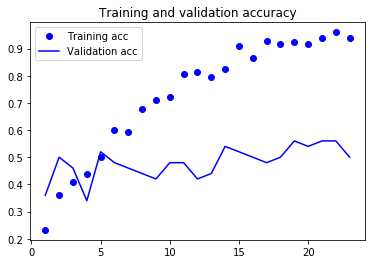

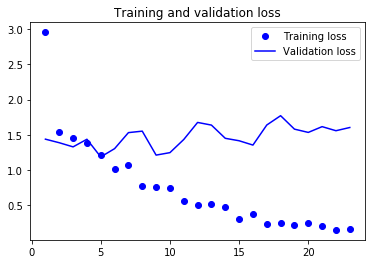

In [8]:
# Plotting the results
# Plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

plt.show()

In [9]:
# Evaluating the model 
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Accuracy on test dataset: ', round(test_acc*100), '%' )

50/50 [==============================] - 0s 441us/step
Accuracy on test dataset:  60 %
